In [1]:
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('../data/training/a_data.csv')
labels = pd.read_csv('../data/training/a_labels.csv')

In [3]:
print(repr(labels['Timestamp'][0]))
print(repr(data['Timestamp'][0]))

1489016399.0
1489016347.6607802


In [4]:
data['TimestampToSec'] = data['Timestamp'].astype(int)
grouped = data.groupby('TimestampToSec')

In [6]:
# for every label, look up the corresponding data
#for l in labels:
#    time = labels['Timestamp']
#    slice = grouped.get_group(time)
single_sec_data = grouped.get_group(1489016350)

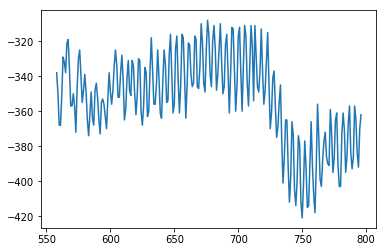

In [8]:
single_sec_ch = single_sec_data['Ch0']

plt.plot(single_sec_ch)
plt.show()

In [22]:
import pywt
import pywt.data

mode = pywt.Modes.smooth

def plot_signal_decomp(data, w, title):
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

        
    print(cd)
    
        
    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure()
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("D%d" % (i + 1))


[array([  1.19904087e-14,  -5.67134630e+00,   5.50617886e+00,
        -7.16674815e+00,   1.01940984e+01,  -6.62871967e+00,
         5.12759647e+00,  -1.94389006e+00,   1.14781745e+01,
        -1.39065425e+00,  -6.41256195e+00,   8.46302200e+00,
        -6.50623572e+00,   7.26586931e+00,  -1.12570375e+01,
         1.25601444e+01,  -5.51939823e+00,  -3.84625353e+00,
        -4.99401086e-02,  -1.94629910e+00,   7.26575317e+00,
        -9.30204838e+00,   4.44826902e+00,   2.58088800e+00,
        -8.52168362e+00,   8.04384457e+00,  -6.26755798e+00,
         5.30414518e+00,   4.28587003e+00,  -5.07127135e+00,
         2.38279697e-01,  -5.53981796e+00,   1.07657212e+01,
        -1.62747649e+01,   7.50663922e+00,  -2.20602040e+00,
         1.00976820e+00,   9.24776925e+00,  -1.02112749e+01,
         5.05188119e+00,  -9.05089915e+00,   1.58297524e-01,
         7.27547604e+00,  -1.29334880e+01,   1.44260297e+01,
        -1.33944132e+01,   3.57517747e+00,   2.44262401e+00,
        -1.00627134e+01

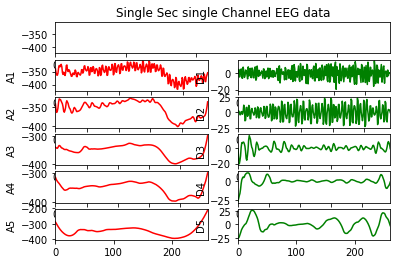

In [23]:
plot_signal_decomp(single_sec_ch, 'db4', "Single Sec single Channel EEG data")
plt.show()